<font size="-1">FALL 2022 
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="60px" align="right">
 </br>
<font size="-01">MATH 404: Linear and Non-Linear Programming</font>

<font size="-1">University of Science and Technology, Zewail City</font>

<br>

<h1 align="center">Research Report 2 Implementation: </h1>
<h2 align="center">Interior Point Methods</h2>
<h2 align="center">Done by: Abdelrahman Elaraby - 201700556</h2>

---


<br> <br> <br>

In this report I will re-implement two variant of the interior point method algorithm; the first is "Central Path" (fixed and adaptive step size) and the second is "Mehrotra Predictor Corrector".
<br>
I will test both alogrithms on 3 test cases (from the lecture notes), and I will compare the results to the ready-made "interior-point-solver" of Scipy Python Library. 
<br>
For my code, I will plot four curves for each test case (with each algorithm of the mentioned two):

1.   the path, Design Variables (solution point) evolving curve
2.   Objective Function Value evolving over iterations
3.   Complementary condition evolving curve over iterations
4.   mu (duality measure) evolvoing curve over iterations


**Input Structure:**<br> I will put the problem in standard form in advance then input to my functions:
*   A (the constraints equations).
*   B (the RHS of constrains equations).
*   C (the OF coefficients.



In [ ]:
# Import used librares
import copy
import numpy as np
from numpy import inf
from numpy import nan 
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import time

In [ ]:
# to ignore warnings
import warnings
warnings. simplefilter(action='ignore', category=FutureWarning)
_ = np.seterr(all="ignore") 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [ ]:
# function #1
def central_path(A, B, C, X0=[], S0=[], Y0=[], alpha=-1, sigma=0.5, epsilon=0.01):
    '''
    Central Path function
    it takes its inputs after putting them in standard form (aka: output of put_to_std_form function)
    it does the looping of the central path interior point algorithm till it terminates.

    INPUTS:
    A: the system of constrtaints' equations with cannonical form
    B: RHS of the constrtaints' equations
    C: Coefficients of Objective Function

    X0,S0,Y0: initial point

    sigma: the centering parameter
    alpha: the step size
    epsilon: stopping criteria (if OF change <= epsilon)

    RETURNS:
    log_vars: containing the following for each iteration :
                  X,  design variables 
                  OF, objective function value
                  XS, Complementary condition
                  mu, duality measure
    '''

    ################################################################
    # adjust the inputs in numpy format
    A = np.array(A)
    B = np.array(B)
    B = B.reshape((len(B),1)) # adjusting the shape of B
    C = np.array(C)
    C = C.reshape((len(C),1)) # adjusting the shape of C

    # getting problem dimensions
    n = A.shape[1]
    m = A.shape[0]

    # set initial point
    # dummy zeros initializations
    X = np.zeros((n, 1))
    S = np.zeros((n, 1))
    Y = np.ones((m, 1))

    # helping vars
    e_n = np.ones((n,1))
    delta_x = 0
    delta_y = 0
    delta_s = 0

    # if given initial points
    if X0 and S0 and Y0:
        X = np.array(X0).reshape((len(X0),1))
        S = np.array(S0).reshape((len(S0),1))
        Y = np.array(Y0).reshape((len(Y0),1))
    # if not given initials, then do heuristic
    else:
        AAt_inv = np.linalg.inv(A@A.T) 
        X_bar = A.T@AAt_inv@B
        Y_bar = AAt_inv@A@C
        S_bar = C - A.T@Y_bar

        d_X = float(np.max([-1.5*np.min(X_bar), 0]))
        d_S = float(np.max([-1.5*np.min(S_bar), 0]))

        d_X_bar = float(d_X + 0.5*(((X_bar+d_X*e_n).T@(S_bar+d_S*e_n))/(np.sum(S_bar+d_S))))
        d_S_bar = float(d_S + 0.5*(((X_bar+d_X*e_n).T@(S_bar+d_S*e_n))/(np.sum(X_bar+d_X))))

        X = X_bar + d_X_bar*e_n
        Y = Y_bar
        S = S_bar + d_S_bar*e_n

    # for printing
    log_vars = {"X":[], "OF":[], "XS":[], "mu":[]}

    of_difference = float('inf') # for termination comparison

    # for i in range(num_iter): # old for loop in case of determined num of iterarions
    while of_difference > epsilon:
        # save logs
        OF = np.matmul(C.T, X) # objective function
        last_of = OF # for termination comparison
        log_vars["X"].append(X)
        log_vars["OF"].append(OF)

        # generate matrices from the vectors
        X_mat = np.diag(X.reshape(1,-1)[0].tolist())
        S_mat = np.diag(S.reshape(1,-1)[0].tolist())
        # save logs
        XS = X_mat@S_mat@e_n
        log_vars["XS"].append(XS)

        # compute residuals
        mu = np.matmul(X.T,S)/n # calculate the duality measure and centering value
        log_vars["mu"].append(mu) # save logs
        mu = (mu* sigma*e_n)

        r_c = A.T@Y + S - C
        r_b = A@X - B
        r_xs = X_mat@S_mat@e_n - sigma*mu

        # slove for deltas
        S_inv = np.linalg.inv(S_mat)
        D_2 = S_inv@X_mat
        delta_y = np.linalg.inv(A @ D_2 @ A.T) @ (-r_b - A@D_2@r_c + A@S_inv@r_xs)
        delta_s = -r_c - A.T@delta_y
        delta_x = -S_inv@r_xs - D_2@delta_s

        if alpha == -1: # do adaptive step size
            # find step sizes (primal and dual)
            eta = np.max([0.995, 1-np.matmul(X.T,S)/n])

            indx = np.where(delta_x < 0) # negative only
            if len(indx[0]) == 0:
                alpha_primal = 1
            else:
                dx_no = delta_x[indx]
                x_no  = X[indx]
                alpha_primal = np.min([1, eta*np.min(-1*np.multiply(x_no, 1./dx_no))])

            indx = np.where(delta_s < 0) # negative only
            if len(indx[0]) == 0:
                alpha_dual = 1
            else:
                ds_no = delta_s[indx]
                s_no  = S[indx]
                alpha_dual = np.min([1, eta*np.min(-1*np.multiply(s_no, 1./ds_no))])
        else:
            alpha_primal = alpha
            alpha_dual = alpha

        ### update to new point
        X = X + alpha_primal*delta_x
        Y = Y + alpha_dual*delta_y
        S = S + alpha_dual*delta_s
        
        OF = np.matmul(C.T, X)
        current_of = OF # for termination comparison
        of_difference = np.abs(current_of - last_of)
        # print(f'OF Difference: {of_difference}')

    # last iteration save logs
    log_vars["X"].append(X)
    log_vars["OF"].append(OF)
    X_mat = np.diag(X.reshape(1,-1)[0].tolist())
    S_mat = np.diag(S.reshape(1,-1)[0].tolist())
    XS = X_mat@S_mat@e_n
    log_vars["XS"].append(XS)
    mu = np.matmul(X.T,S)/n
    log_vars["mu"].append(mu)
    
    return log_vars

In [ ]:
# function #2
def Mehrotra_Algorithm(A, B, C, X0=[], S0=[], Y0=[], epsilon=0.01):
    '''
    Mehrotra Predictor-Corrector function
    it takes its inputs after putting them in standard form (aka: output of put_to_std_form function)
    it does the looping of the Mehrotra Predictor-Corrector algorithm till it terminates.

    INPUTS:
    A: the system of constrtaints' equations with cannonical form
    B: RHS of the constrtaints' equations
    C: Coefficients of Objective Function

    X0,S0,Y0: initial point

    sigma: the centering parameter
    alpha: the step size
    epsilon: stopping criteria (if OF change <= epsilon)
    inv_jac: choose inverse jacobian approach instead of system of equations

    RETURNS:
    log_vars: containing the following for each iteration :
                  X,  design variables 
                  OF, objective function value
                  XS, Complementary condition
                  mu, duality measure
    '''

    ################################################################
    # adjust the inputs in numpy format
    A = np.array(A)
    B = np.array(B)
    B = B.reshape((len(B),1)) # adjusting the shape of B
    C = np.array(C)
    C = C.reshape((len(C),1)) # adjusting the shape of C

    # getting problem dimensions
    n = A.shape[1]
    m = A.shape[0]

    # set initial point
    # dummy zeros initializations
    X = np.zeros((n, 1))
    S = np.zeros((n, 1))
    Y = np.ones((m, 1))

    # helping variables
    e_n = np.ones((n,1))

    # for printing
    log_vars = {"X":[], "OF":[], "XS":[], "mu":[]}

    # if given initial points
    if X0 and S0 and Y0:
        X = np.array(X0).reshape((len(X0),1))
        S = np.array(S0).reshape((len(S0),1))
        Y = np.array(Y0).reshape((len(Y0),1))
    # if not given initials, then do heuristic
    else:
        AAt_inv = np.linalg.inv(A@A.T) 
        X_bar = A.T@AAt_inv@B
        Y_bar = AAt_inv@A@C
        S_bar = C - A.T@Y_bar

        d_X = float(np.max([-1.5*np.min(X_bar), 0]))
        d_S = float(np.max([-1.5*np.min(S_bar), 0]))

        d_X_bar = float(d_X + 0.5*(((X_bar+d_X*e_n).T@(S_bar+d_S*e_n))/(np.sum(S_bar+d_S))))
        d_S_bar = float(d_S + 0.5*(((X_bar+d_X*e_n).T@(S_bar+d_S*e_n))/(np.sum(X_bar+d_X))))

        X = X_bar + d_X_bar*e_n
        Y = Y_bar
        S = S_bar + d_S_bar*e_n

    # saving logs
    log_vars["X"].append(X)
    OF = np.matmul(C.T, X)
    log_vars["OF"].append(OF)
    X_mat = np.diag(X.reshape(1,-1)[0].tolist())
    S_mat = np.diag(S.reshape(1,-1)[0].tolist())
    XS = X_mat@S_mat@e_n
    log_vars["XS"].append(XS)
    mu = np.matmul(X.T,S)/n
    log_vars["mu"].append(mu)

    # main algorithm loop    
    while True:
        ## 1: Affine-Scaling (Predictor) Step
        # generate matrices from the vectors
        X_mat = np.diag(X.reshape(1,-1)[0].tolist())
        S_mat = np.diag(S.reshape(1,-1)[0].tolist())

        # compute residuals
        r_c = A.T@Y + S - C
        r_b = A@X - B
        r_xs = X_mat@S_mat@e_n

        # compute mu
        mu = np.matmul(X.T,S)/n # calculate the duality measure and centering value

        # test for optimality
        test = np.max([float(mu), np.linalg.norm(r_c), np.linalg.norm(r_b)])
        if test <= epsilon:
            break # end the loop

        # slove for deltas
        S_inv = np.linalg.inv(S_mat)
        D_2 = S_inv@X_mat
        delta_y_aff = np.linalg.inv(A @ D_2 @ A.T) @ (-r_b - A@D_2@r_c + A@S_inv@r_xs)
        delta_s_aff = -r_c - A.T@delta_y_aff
        delta_x_aff = -S_inv@r_xs - D_2@delta_s_aff

        # calculate alphas, and mu_aff, and sigma
        indx = np.where(delta_x_aff < 0) # negative only
        if len(indx[0]) == 0:
            alpha_primal_aff = 1
        else:
            dx_no = delta_x_aff[indx]
            x_no  = X[indx]
            ratio_primal = np.min(-1*np.multiply(x_no, 1./dx_no))
            alpha_primal_aff = np.min([1, ratio_primal])

        indx = np.where(delta_s_aff < 0) # negative only
        if len(indx[0]) == 0:
            alpha_dual_aff = 1
        else:
            ds_no = delta_s_aff[indx]
            s_no  = S[indx]
            ratio_dual = np.min(-1*np.multiply(s_no, 1./ds_no))
            alpha_dual_aff = np.min([1, ratio_dual])

        mu_aff = ((X+ alpha_primal_aff*delta_x_aff).T @ (S + alpha_dual_aff*delta_s_aff))/n
        sigma = (mu_aff/mu)**3

        ## 2: Corrector Step

        # generate matrices from the vectors
        delta_x_aff_mat = np.diag(delta_x_aff.reshape(1,-1)[0].tolist())
        delta_s_aff_mat = np.diag(delta_s_aff.reshape(1,-1)[0].tolist())
        # update last residual
        r_xs = X_mat@S_mat@e_n + delta_x_aff_mat@delta_s_aff_mat@e_n - sigma*mu # The predictor, corrector, and centering contributions.
        # slove for deltas
        S_inv = np.linalg.inv(S_mat)
        D_2 = S_inv@X_mat
        delta_y = np.linalg.inv(A @ D_2 @ A.T) @ (-r_b - A@D_2@r_c + A@S_inv@r_xs)
        delta_s = -r_c - A.T@delta_y
        delta_x = -S_inv@r_xs - D_2@delta_s

        # find step sizes (primal and dual)
        eta = np.max([0.995, 1-mu])

        indx = np.where(delta_x < 0) # negative only
        if len(indx[0]) == 0:
            alpha_primal = 1
        else:
            dx_no = delta_x[indx]
            x_no  = X[indx]
            alpha_primal = np.min([1, eta*np.min(-1*np.multiply(x_no, 1./dx_no))])

        indx = np.where(delta_s < 0) # negative only
        if len(indx[0]) == 0:
            alpha_dual = 1
        else:
            ds_no = delta_s[indx]
            s_no  = S[indx]
            alpha_dual = np.min([1, eta*np.min(-1*np.multiply(s_no, 1./ds_no))])

        ### update to new point
        X = X + alpha_primal*delta_x
        Y = Y + alpha_dual*delta_y
        S = S + alpha_dual*delta_s

        # saving logs
        log_vars["X"].append(X)
        OF = np.matmul(C.T, X)
        log_vars["OF"].append(OF)
        X_mat = np.diag(X.reshape(1,-1)[0].tolist())
        S_mat = np.diag(S.reshape(1,-1)[0].tolist())
        XS = X_mat@S_mat@e_n
        log_vars["XS"].append(XS)
        mu = np.matmul(X.T,S)/n
        log_vars["mu"].append(mu)
    return log_vars

In [ ]:
C = [1, 0, -1, -3]
A = [[2, 0, 2, 3], [0, -2, -2, -6]]
B = [10, -6]

logs = Mehrotra_Algorithm(A, B, C, epsilon=0.0001)

# **Testing and Comparisons:**

NOTE: if you want adaptive step size for centeral path, then don't input a value for alpha to the function (or input it with -1).

**Test Case 1:**

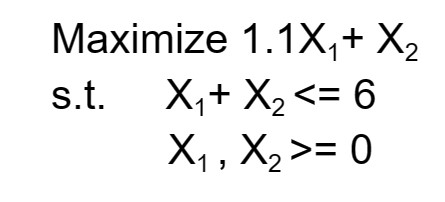

In [ ]:
C = [-1.1, -1, 0] 
A = [[1, 1, 1]]
B = [6]

logs_cp = central_path(A, B, C , X0=[5,6,1], S0=[1,1,1], Y0=[0.5], sigma=0.5, alpha=0.9, epsilon=0.0001)
logs_m = Mehrotra_Algorithm(A, B, C, X0=[5,6,1], S0=[1,1,1], Y0=[0.5], epsilon=0.0001)

print(f'For Central Path:')
print(f'Final X values: {logs_cp["X"][-1]}')
print(f'Final OF value: {logs_cp["OF"][-1]}')
print(f'--------------------------------------')
print(f'For Mehrotra:')
print(f'Final X values: {logs_m["X"][-1]}')
print(f'Final OF value: {logs_m["OF"][-1]}')

For Central Path:
Final X values: [[5.99991140e+00]
 [8.12213145e-05]
 [7.38109486e-06]]
Final OF value: [[-6.59998376]]
--------------------------------------
For Mehrotra:
Final X values: [[5.99999364e+00]
 [6.27362513e-06]
 [8.96100143e-08]]
Final OF value: [[-6.59999927]]


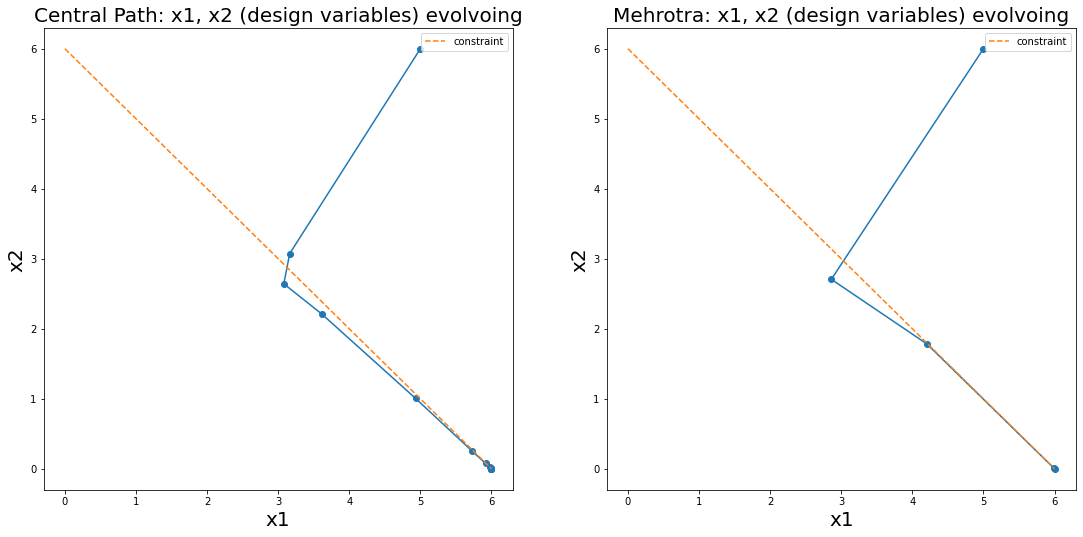

In [ ]:
# print x1, x2 (design variables) evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
X = logs_cp["X"]
x1 = [float(x[0]) for x in X]
x2 = [float(x[1]) for x in X]

ax1.plot(x1, x2, marker="o")
ax1.set_title("Central Path: x1, x2 (design variables) evolvoing", fontsize=20)
ax1.set_xlabel("x1", fontsize=20)
ax1.set_ylabel("x2", fontsize=20)
ax1.plot([0, 6], [6, 0], linestyle='dashed', label="constraint") # plot constraint
ax1.legend()

#### Mehrotra 
X = logs_m["X"]
x1 = [float(x[0]) for x in X]
x2 = [float(x[1]) for x in X]

ax2.plot(x1, x2, marker="o")
ax2.set_title("Mehrotra: x1, x2 (design variables) evolvoing", fontsize=20)
ax2.set_xlabel("x1", fontsize=20)
ax2.set_ylabel("x2", fontsize=20)
ax2.plot([0, 6], [6, 0], linestyle='dashed', label="constraint") # plot constraint
ax2.legend()
plt.show()

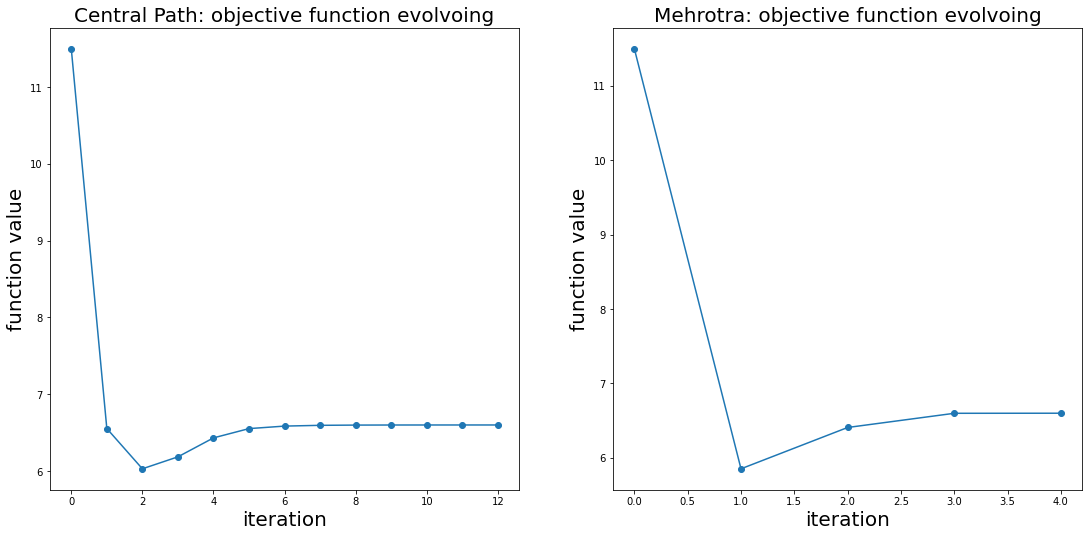

In [ ]:
# print objective function evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
OF = logs_cp["OF"]
OF = [float(f)*-1 for f in OF]
iteration = [i for i in range(len(OF))]

ax1.plot(iteration, OF, marker='o')
ax1.set_title("Central Path: objective function evolvoing", fontsize=20)
ax1.set_xlabel("iteration", fontsize=20)
ax1.set_ylabel("function value", fontsize=20)

#### Mehrotra 
OF = logs_m["OF"]
OF = [float(f)*-1 for f in OF]
iteration = [i for i in range(len(OF))]

ax2.plot(iteration, OF, marker='o')
ax2.set_title("Mehrotra: objective function evolvoing", fontsize=20)
ax2.set_xlabel("iteration", fontsize=20)
ax2.set_ylabel("function value", fontsize=20)
plt.show()

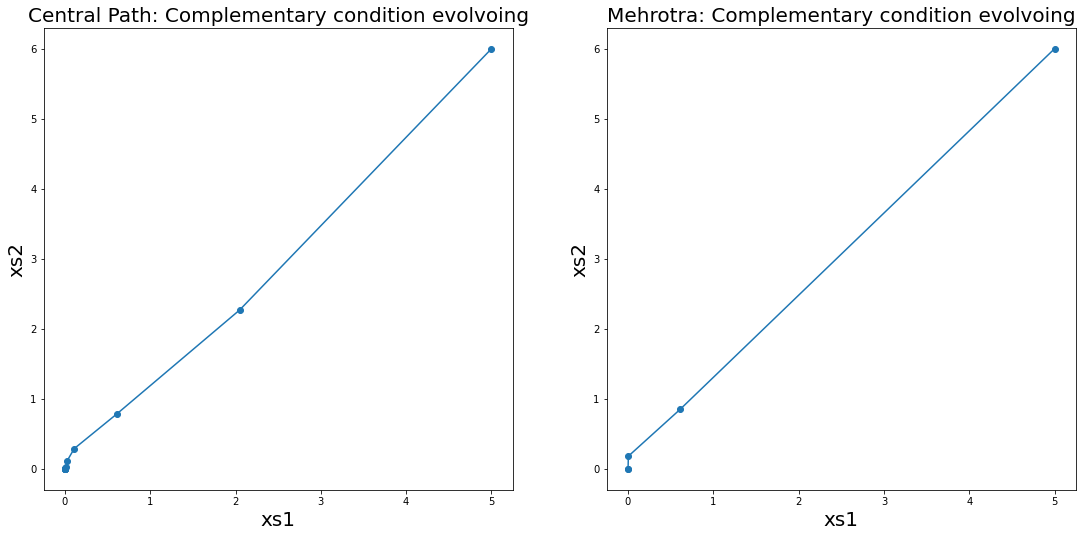

In [ ]:
# Complementary condition evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
XS = logs_cp["XS"]
xs1 = [float(xs[0]) for xs in XS]
xs2 = [float(xs[1]) for xs in XS]

ax1.plot(xs1, xs2, marker='o')
ax1.set_title("Central Path: Complementary condition evolvoing", fontsize=20)
ax1.set_xlabel("xs1", fontsize=20)
ax1.set_ylabel("xs2", fontsize=20)

#### Mehrotra 
XS = logs_m["XS"]
xs1 = [float(xs[0]) for xs in XS]
xs2 = [float(xs[1]) for xs in XS]

ax2.plot(xs1, xs2, marker='o')
ax2.set_title("Mehrotra: Complementary condition evolvoing", fontsize=20)
ax2.set_xlabel("xs1", fontsize=20)
ax2.set_ylabel("xs2", fontsize=20)
plt.show()

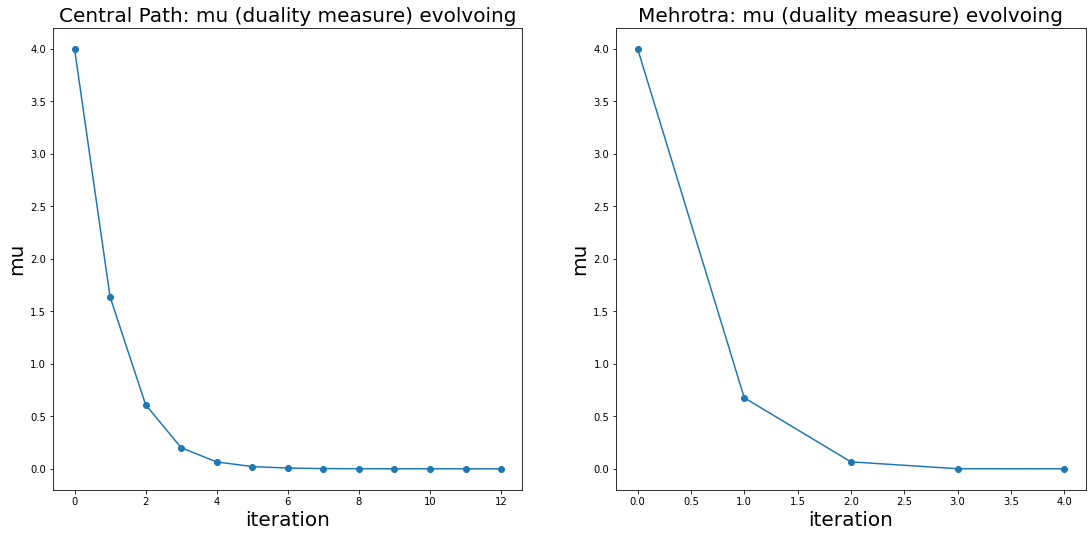

In [ ]:
# mu (duality measure) evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
mu = logs_cp["mu"]
mu = [float(m) for m in mu]
iteration = [i for i in range(len(mu))]

ax1.plot(iteration, mu, marker='o')
ax1.set_title("Central Path: mu (duality measure) evolvoing", fontsize=20)
ax1.set_xlabel("iteration", fontsize=20)
ax1.set_ylabel("mu", fontsize=20)

#### Mehrotra 
mu = logs_m["mu"]
mu = [float(m) for m in mu]
iteration = [i for i in range(len(mu))]

ax2.plot(iteration, mu, marker='o')
ax2.set_title("Mehrotra: mu (duality measure) evolvoing", fontsize=20)
ax2.set_xlabel("iteration", fontsize=20)
ax2.set_ylabel("mu", fontsize=20)
plt.show()

**Test Case 2:**

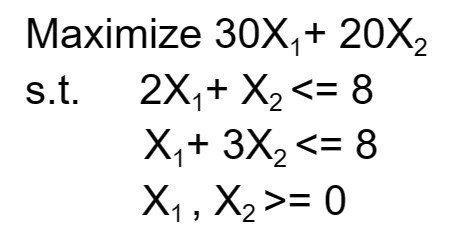

In [ ]:
C = [-30, -20, 0, 0] 
A = [[2, 1, 1, 0], [1, 3, 0, 1]]
B = [8, 8]

logs_cp = central_path(A, B, C, sigma=0.5, epsilon=0.0001)
logs_m = Mehrotra_Algorithm(A, B, C, epsilon=0.0001)

print(f'For Central Path:')
print(f'Final X values: {logs_cp["X"][-1]}')
print(f'Final OF value: {logs_cp["OF"][-1]}')
print(f'--------------------------------------')
print(f'For Mehrotra:')
print(f'Final X values: {logs_m["X"][-1]}')
print(f'Final OF value: {logs_m["OF"][-1]}')

For Central Path:
Final X values: [[3.20000050e+00]
 [1.59999836e+00]
 [6.29430304e-07]
 [4.40603986e-06]]
Final OF value: [[-127.99998238]]
--------------------------------------
For Mehrotra:
Final X values: [[3.20000004e+00]
 [1.59999992e+00]
 [2.72148214e-09]
 [1.93318105e-07]]
Final OF value: [[-127.99999958]]


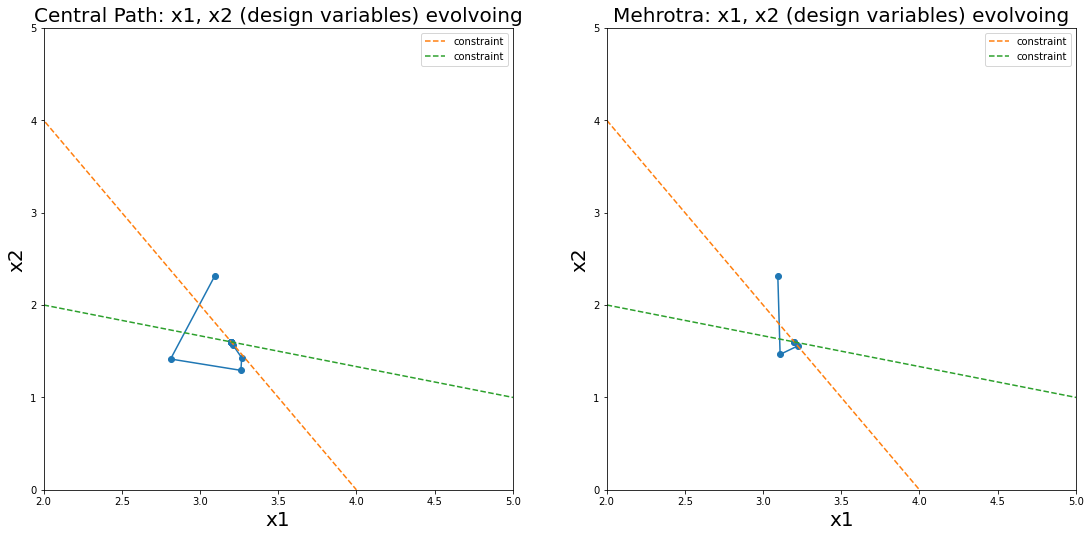

In [ ]:
# print x1, x2 (design variables) evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
X = logs_cp["X"]
x1 = [float(x[0]) for x in X]
x2 = [float(x[1]) for x in X]

ax1.plot(x1, x2, marker="o")
ax1.set_title("Central Path: x1, x2 (design variables) evolvoing", fontsize=20)
ax1.set_xlabel("x1", fontsize=20)
ax1.set_ylabel("x2", fontsize=20)
ax1.plot([0, 4], [8, 0], linestyle='dashed', label="constraint") # plot constraint
ax1.plot([2, 8], [2, 0], linestyle='dashed', label="constraint") # plot constraint
ax1.legend()
ax1.set_xlim([2, 5])
ax1.set_ylim([0, 5])

#### Mehrotra 
X = logs_m["X"]
x1 = [float(x[0]) for x in X]
x2 = [float(x[1]) for x in X]

ax2.plot(x1, x2, marker="o")
ax2.set_title("Mehrotra: x1, x2 (design variables) evolvoing", fontsize=20)
ax2.set_xlabel("x1", fontsize=20)
ax2.set_ylabel("x2", fontsize=20)
ax2.plot([0, 4], [8, 0], linestyle='dashed', label="constraint") # plot constraint
ax2.plot([2, 8], [2, 0], linestyle='dashed', label="constraint") # plot constraint
ax2.legend()
ax2.set_xlim([2, 5])
ax2.set_ylim([0, 5])
plt.show()

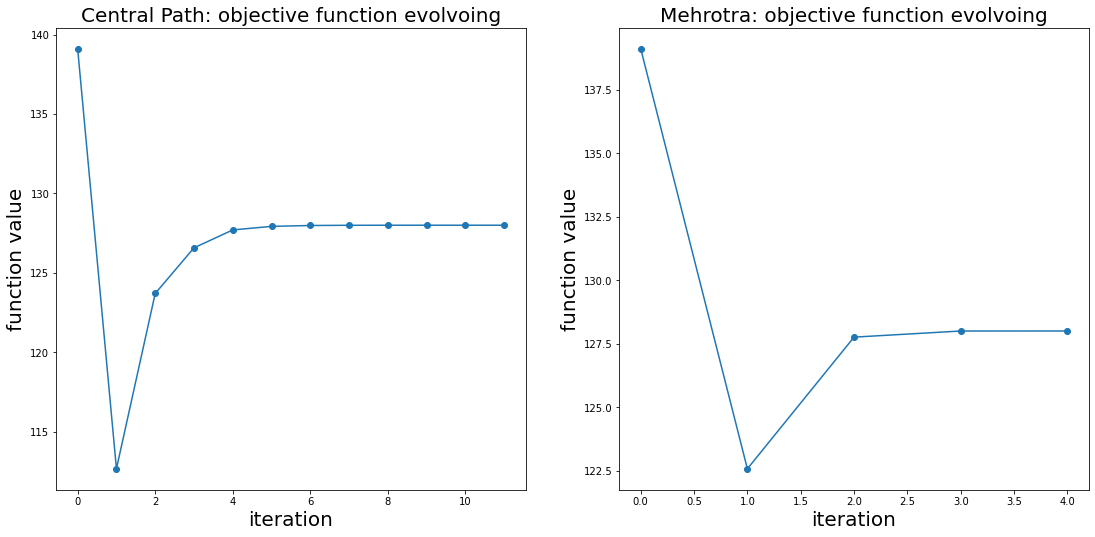

In [ ]:
# print objective function evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
OF = logs_cp["OF"]
OF = [float(f)*-1 for f in OF]
iteration = [i for i in range(len(OF))]

ax1.plot(iteration, OF, marker='o')
ax1.set_title("Central Path: objective function evolvoing", fontsize=20)
ax1.set_xlabel("iteration", fontsize=20)
ax1.set_ylabel("function value", fontsize=20)

#### Mehrotra 
OF = logs_m["OF"]
OF = [float(f)*-1 for f in OF]
iteration = [i for i in range(len(OF))]

ax2.plot(iteration, OF, marker='o')
ax2.set_title("Mehrotra: objective function evolvoing", fontsize=20)
ax2.set_xlabel("iteration", fontsize=20)
ax2.set_ylabel("function value", fontsize=20)
plt.show()

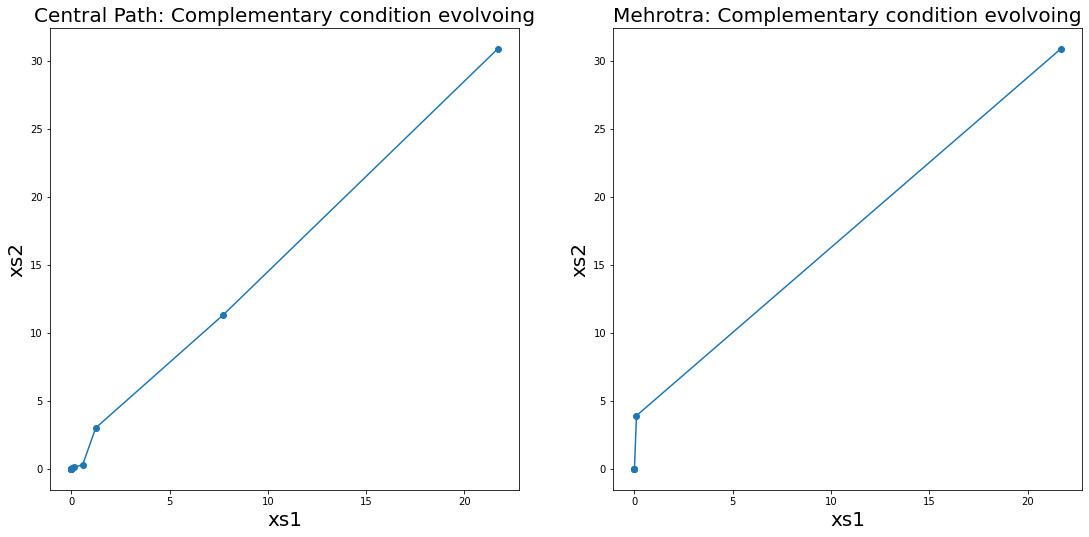

In [ ]:
# Complementary condition evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
XS = logs_cp["XS"]
xs1 = [float(xs[0]) for xs in XS]
xs2 = [float(xs[1]) for xs in XS]

ax1.plot(xs1, xs2, marker='o')
ax1.set_title("Central Path: Complementary condition evolvoing", fontsize=20)
ax1.set_xlabel("xs1", fontsize=20)
ax1.set_ylabel("xs2", fontsize=20)

#### Mehrotra 
XS = logs_m["XS"]
xs1 = [float(xs[0]) for xs in XS]
xs2 = [float(xs[1]) for xs in XS]

ax2.plot(xs1, xs2, marker='o')
ax2.set_title("Mehrotra: Complementary condition evolvoing", fontsize=20)
ax2.set_xlabel("xs1", fontsize=20)
ax2.set_ylabel("xs2", fontsize=20)
plt.show()

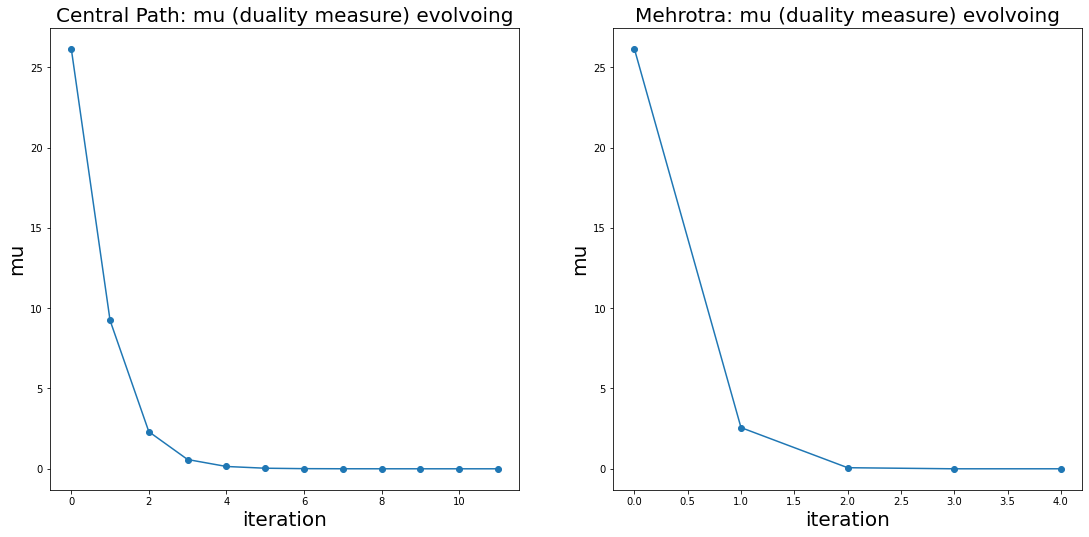

In [ ]:
# mu (duality measure) evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
mu = logs_cp["mu"]
mu = [float(m) for m in mu]
iteration = [i for i in range(len(mu))]

ax1.plot(iteration, mu, marker='o')
ax1.set_title("Central Path: mu (duality measure) evolvoing", fontsize=20)
ax1.set_xlabel("iteration", fontsize=20)
ax1.set_ylabel("mu", fontsize=20)

#### Mehrotra 
mu = logs_m["mu"]
mu = [float(m) for m in mu]
iteration = [i for i in range(len(mu))]

ax2.plot(iteration, mu, marker='o')
ax2.set_title("Mehrotra: mu (duality measure) evolvoing", fontsize=20)
ax2.set_xlabel("iteration", fontsize=20)
ax2.set_ylabel("mu", fontsize=20)
plt.show()

**Test Case 3:**

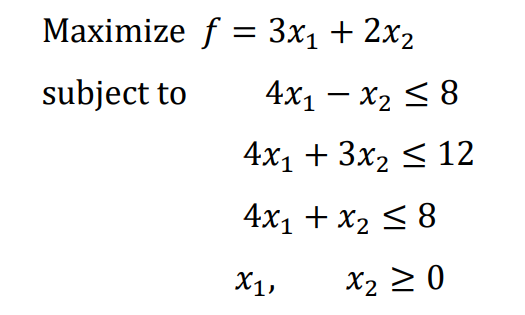

In [ ]:
C = [-3, -2, 0, 0, 0] 
A = [[4, -1, 1, 0, 0], [4, 3, 0, 1, 0], [4, 1, 0, 0, 1]]
B = [8, 12, 8]

logs_cp = central_path(A, B, C, sigma=0.5, epsilon=0.0001)
logs_m = Mehrotra_Algorithm(A, B, C, epsilon=0.0001)

print(f'For Central Path:')
print(f'Final X values: {logs_cp["X"][-1]}')
print(f'Final OF value: {logs_cp["OF"][-1]}')
print(f'--------------------------------------')
print(f'For Mehrotra:')
print(f'Final X values: {logs_m["X"][-1]}')
print(f'Final OF value: {logs_m["OF"][-1]}')

For Central Path:
Final X values: [[1.49997676e+00]
 [2.00002656e+00]
 [4.00011950e+00]
 [1.32826667e-05]
 [6.63927389e-05]]
Final OF value: [[-8.4999834]]
--------------------------------------
For Mehrotra:
Final X values: [[1.49964502e+00]
 [2.00046915e+00]
 [4.00188908e+00]
 [1.24637639e-05]
 [9.50773406e-04]]
Final OF value: [[-8.49987336]]


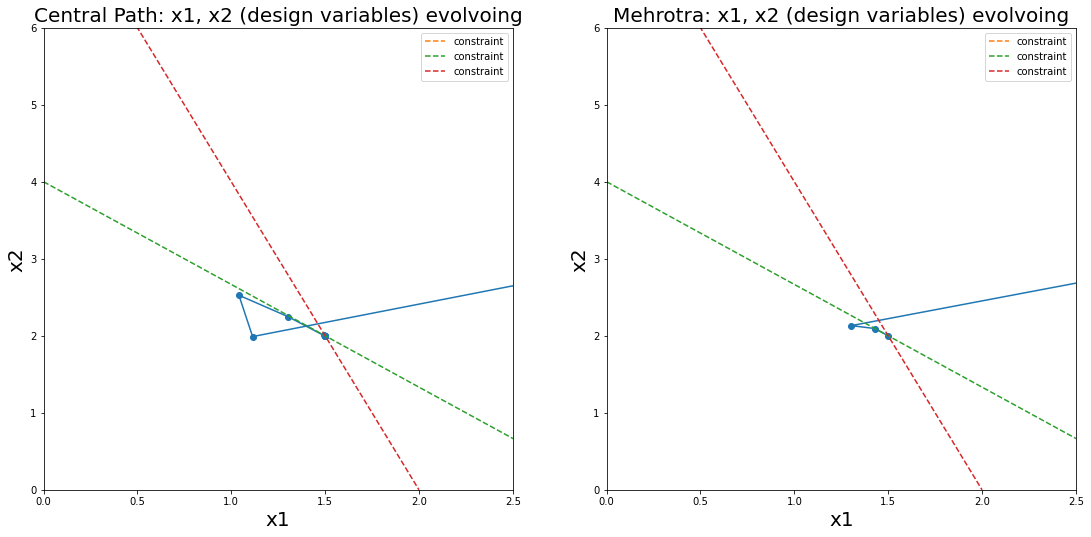

In [ ]:
# print x1, x2 (design variables) evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
X = logs_cp["X"]
x1 = [float(x[0]) for x in X]
x2 = [float(x[1]) for x in X]

ax1.plot(x1, x2, marker="o")
ax1.set_title("Central Path: x1, x2 (design variables) evolvoing", fontsize=20)
ax1.set_xlabel("x1", fontsize=20)
ax1.set_ylabel("x2", fontsize=20)
ax1.plot([0, 2], [-8, 0], linestyle='dashed', label="constraint") # plot constraint
ax1.plot([0, 3], [4, 0], linestyle='dashed', label="constraint") # plot constraint
ax1.plot([0, 2], [8, 0], linestyle='dashed', label="constraint") # plot constraint
ax1.legend()
ax1.set_xlim([0, 2.5])
ax1.set_ylim([0, 6])

#### Mehrotra 
X = logs_m["X"]
x1 = [float(x[0]) for x in X]
x2 = [float(x[1]) for x in X]

ax2.plot(x1, x2, marker="o")
ax2.set_title("Mehrotra: x1, x2 (design variables) evolvoing", fontsize=20)
ax2.set_xlabel("x1", fontsize=20)
ax2.set_ylabel("x2", fontsize=20)
ax2.plot([0, 2], [-8, 0], linestyle='dashed', label="constraint") # plot constraint
ax2.plot([0, 3], [4, 0], linestyle='dashed', label="constraint") # plot constraint
ax2.plot([0, 2], [8, 0], linestyle='dashed', label="constraint") # plot constraint
ax2.legend()
ax2.set_xlim([0, 2.5])
ax2.set_ylim([0, 6])
plt.show()

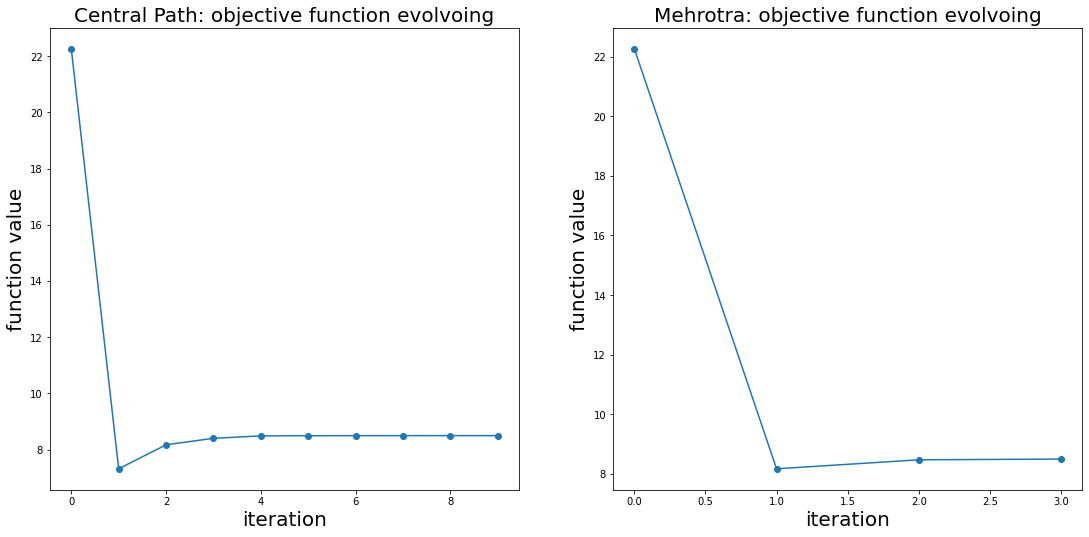

In [ ]:
# print objective function evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
OF = logs_cp["OF"]
OF = [float(f)*-1 for f in OF]
iteration = [i for i in range(len(OF))]

ax1.plot(iteration, OF, marker='o')
ax1.set_title("Central Path: objective function evolvoing", fontsize=20)
ax1.set_xlabel("iteration", fontsize=20)
ax1.set_ylabel("function value", fontsize=20)

#### Mehrotra 
OF = logs_m["OF"]
OF = [float(f)*-1 for f in OF]
iteration = [i for i in range(len(OF))]

ax2.plot(iteration, OF, marker='o')
ax2.set_title("Mehrotra: objective function evolvoing", fontsize=20)
ax2.set_xlabel("iteration", fontsize=20)
ax2.set_ylabel("function value", fontsize=20)
plt.show()

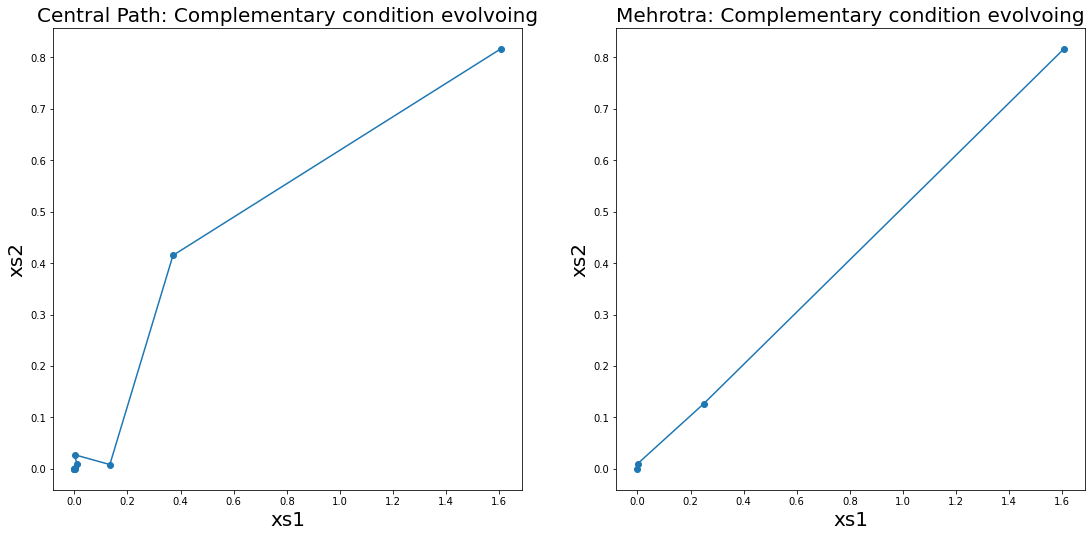

In [ ]:
# Complementary condition evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
XS = logs_cp["XS"]
xs1 = [float(xs[0]) for xs in XS]
xs2 = [float(xs[1]) for xs in XS]

ax1.plot(xs1, xs2, marker='o')
ax1.set_title("Central Path: Complementary condition evolvoing", fontsize=20)
ax1.set_xlabel("xs1", fontsize=20)
ax1.set_ylabel("xs2", fontsize=20)

#### Mehrotra 
XS = logs_m["XS"]
xs1 = [float(xs[0]) for xs in XS]
xs2 = [float(xs[1]) for xs in XS]

ax2.plot(xs1, xs2, marker='o')
ax2.set_title("Mehrotra: Complementary condition evolvoing", fontsize=20)
ax2.set_xlabel("xs1", fontsize=20)
ax2.set_ylabel("xs2", fontsize=20)
plt.show()

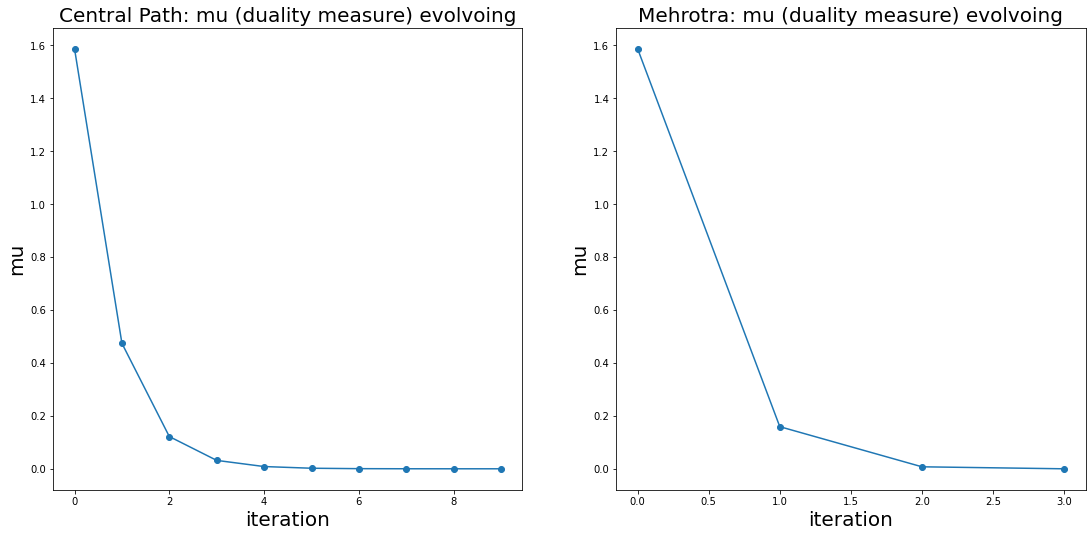

In [ ]:
# mu (duality measure) evolvoing, for 2 algorithms
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
#### Central Path 
mu = logs_cp["mu"]
mu = [float(m) for m in mu]
iteration = [i for i in range(len(mu))]

ax1.plot(iteration, mu, marker='o')
ax1.set_title("Central Path: mu (duality measure) evolvoing", fontsize=20)
ax1.set_xlabel("iteration", fontsize=20)
ax1.set_ylabel("mu", fontsize=20)

#### Mehrotra 
mu = logs_m["mu"]
mu = [float(m) for m in mu]
iteration = [i for i in range(len(mu))]

ax2.plot(iteration, mu, marker='o')
ax2.set_title("Mehrotra: mu (duality measure) evolvoing", fontsize=20)
ax2.set_xlabel("iteration", fontsize=20)
ax2.set_ylabel("mu", fontsize=20)
plt.show()

# Comparison with Scipy:

In [ ]:
# using my code
C = [-3, -2, 0, 0, 0] 
A = [[4, -1, 1, 0, 0], [4, 3, 0, 1, 0], [4, 1, 0, 0, 1]]
B = [8, 12, 8]

start_t = time.time()
logs_cp = central_path(A, B, C, sigma=0.5, epsilon=0.0001)
logs_m = Mehrotra_Algorithm(A, B, C, epsilon=0.0001)
end_t = time.time()
total_time = end_t-start_t

print("----------------------------------")
print(f'Time taken (in seconds): {total_time}')

----------------------------------
Time taken (in seconds): 0.02972412109375


In [ ]:
print(f'For Central Path:')
print(f'Final X values: {logs_cp["X"][-1]}')
print(f'Final OF value: {logs_cp["OF"][-1]}')
print(f'--------------------------------------')
print(f'For Mehrotra:')
print(f'Final X values: {logs_m["X"][-1]}')
print(f'Final OF value: {logs_m["OF"][-1]}')

For Central Path:
Final X values: [[1.49997676e+00]
 [2.00002656e+00]
 [4.00011950e+00]
 [1.32826667e-05]
 [6.63927389e-05]]
Final OF value: [[-8.4999834]]
--------------------------------------
For Mehrotra:
Final X values: [[1.49964502e+00]
 [2.00046915e+00]
 [4.00188908e+00]
 [1.24637639e-05]
 [9.50773406e-04]]
Final OF value: [[-8.49987336]]


In [ ]:
# using scipy code
c = [-3, -2]
A = [[4, -1], [4, 3], [4, 1]]
b = [8, 12, 8]

x0_bounds = (0, None)
x1_bounds = (0, None)

start_t = time.time()
res = linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds], method="interior-point")
res = linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds], method="interior-point")
end_t = time.time()
total_time = end_t-start_t


print("----------------------------------")
print(f'Time taken (in seconds): {total_time}')

----------------------------------
Time taken (in seconds): 0.016368389129638672


In [ ]:
print(f'Using Scipy:')
print(f'Final X values: {res["x"]}')
print(f'Final OF value: {res["fun"]}')

Using Scipy:
Final X values: [1.5 2. ]
Final OF value: -8.499999998072843


## Some Comments:



*   in all examples it was clear that Mehrotra finishes before the central path (less number of iterations but more computationally expensive) 
*   when comparing to ready-made (Scipy), both of my 2 functions and the scipy function outputed similar values.
*   when doing time comparison between my code and the ready made, I made the evaluation on 2 experiments; interestingly, 2 runs of my functions (one of them is mehrotra and the other is central path) ended faster 2 runs of the ready made. I think the possible reasons for this could be:
  * putting the problem in std form; I did that in advance while the scipy do it inside the algorithm 
  * maybe the "interior-point" solver of numpy uses heavier algorithm in both runs (e.g.both runs are mehrotra) while my code uses one heavy (mehrotra) and one simple (central path)

